In [94]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar, line_search
import matplotlib.pyplot as plt
import scipy.linalg as sla

In [2]:
m = 10

def f(c):
    return np.outer(c, c)

def apply_df_dc(c, h):
    return  np.outer(c, h) + np.outer(h, c)

c0 = np.random.randn(m)
f0 = f(c0)
h = np.random.randn(m)
df_dc_h = apply_df_dc(c0, h)

s = 1e-6
c1 = c0 + s*h
f1 = f(c1)

df_dc_h_diff = (f1 - f0) / s
err_df_dc = np.linalg.norm(df_dc_h_diff - df_dc_h) / np.linalg.norm(df_dc_h_diff)
print('s=', s, ', err_df_dc=', err_df_dc)

s= 1e-06 , err_df_dc= 9.799028255924239e-07


In [3]:
def G(c):
    return 2.0 * np.dot(c, c) * np.eye(len(c)) + 2.0 * np.outer(c, c)

u = np.random.randn(m)
v = np.random.randn(m)

IP_true = np.sum(apply_df_dc(c0, u) * apply_df_dc(c0, v))

G0 = G(c0)
IP = np.dot(u, np.dot(G0, v))

err_G = np.linalg.norm(IP_true - IP) / np.linalg.norm(IP_true)
print('err_G=', err_G)

err_G= 5.841764361180644e-16


In [4]:
def H(c, p):
    return np.dot(c, c) * np.dot(p, p) + np.dot(c, p)**2


p0 = np.random.randn(m)
H0 = H(c0, p0)
H0_true = 0.5 * np.dot(p0, np.dot(G(c0), p0))

err_hamiltonian = np.linalg.norm(H0 - H0_true) / np.linalg.norm(H0_true)
print('err_hamiltonian=', err_hamiltonian)


err_hamiltonian= 1.8410521918740012e-16


In [5]:
def dH_dc(c, p):
    return 2.0 * c * np.dot(p, p) + 2.0 * p * np.dot(c, p)

c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

h = np.random.randn(m)
dH_dc_h = np.dot(dH_dc(c0, p0), h)

s = 1e-6
c1 = c0 + s*h

H1 = H(c1, p0)
dH_dc_h_diff = (H1 - H0) / s

err_dH_dc = np.linalg.norm(dH_dc_h_diff - dH_dc_h) / np.linalg.norm(dH_dc_h_diff)
print('s=', s, ', err_dH_dc=', err_dH_dc)

s= 1e-06 , err_dH_dc= 1.639027299583211e-06


In [6]:
def dH_dp(c, p):
    return 2.0 * p * np.dot(c, c) + 2.0 * c * np.dot(p, c)

c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

h = np.random.randn(m)
dH_dp_h = np.dot(dH_dp(c0, p0), h)

s = 1e-6
p1 = p0 + s*h

H1 = H(c0, p1)
dH_dp_h_diff = (H1 - H0) / s

err_dH_dp = np.linalg.norm(dH_dp_h_diff - dH_dp_h) / np.linalg.norm(dH_dp_h_diff)
print('s=', s, ', err_dH_dp=', err_dH_dp)

s= 1e-06 , err_dH_dp= 2.5350852772419147e-06


T= 1.0 , H0= 9.918134105499249 , HT= 9.9064707927364


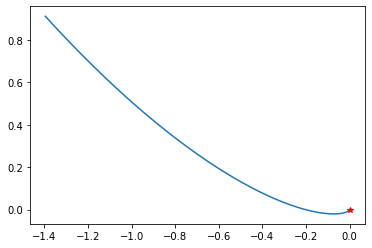

In [7]:
def cdot(c, p):
    return dH_dp(c, p)

def pdot(c, p):
    return -dH_dc(c, p)

def ydot(t, y):
    m = int(len(y)/2)
    c = y[:m]
    p = y[m:]
    return np.concatenate([cdot(c,p), pdot(c,p)])


def geodesic(c0, p0, T, num_pts=None):
    y0 = np.concatenate([c0, p0])
    if num_pts is not None:
        tt = np.linspace(0, T, num_pts)
    else:
        tt = None
    result = solve_ivp(ydot, (0.0, T), y0, t_eval=tt, method='Radau')
    cc = result.y[: len(c0), :]
    pp = result.y[len(c0) :, :]
    return cc, pp

m = 2
c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

T = 1.0

cc, pp = geodesic(c0, p0, T, num_pts=1000)

cT = cc[:,-1]
pT = pp[:,-1]

HT = H(cT, pT)
print('T=', T, ', H0=', H0, ', HT=', HT)

plt.plot(cc[0,:], cc[1,:])
plt.plot(cT[0], cT[1], '*r') # final point

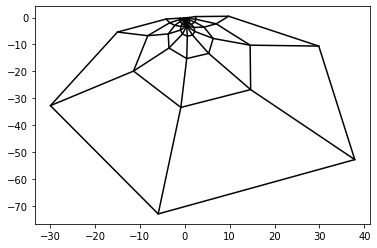

In [8]:
num_radii = 5
num_theta = 15

m = 2
c0 = np.random.randn(m)

thetas = np.linspace(0,2*np.pi, num_theta)
all_p0 = [np.array([np.sin(theta), np.cos(theta)]) for theta in list(thetas)]


T = 0.25

all_cc = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    p0 = all_p0[ii]
    cc, pp = geodesic(c0, p0, T, num_pts=num_radii)
    all_cc[:,:,ii] = cc

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')

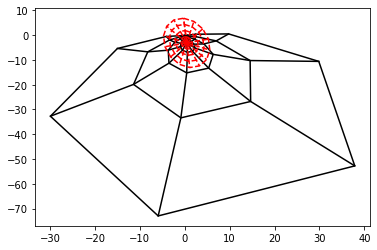

In [9]:
def exp_map(c0, p0, t):
    result = geodesic(c0, p0, t, num_pts=None)
    return result[0][:,-1], result[1][:,-1]

tt = np.linspace(0, T, num_radii)

metric = G(c0)

all_cc = np.zeros((m, num_radii, num_theta))
all_cc_approx = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    for jj in range(num_radii):
        p0 = all_p0[ii]
        all_cc[:,jj,ii] = exp_map(c0, all_p0[ii], tt[jj])[0]
        all_cc_approx[:,jj,ii] = c0 + np.dot(metric, all_p0[ii] * tt[jj])

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')
    
for ii in range(num_theta):
    plt.plot(all_cc_approx[0,:,ii], all_cc_approx[1,:,ii], '--r')
    
for jj in range(num_radii):
    plt.plot(all_cc_approx[0,jj,:], all_cc_approx[1,jj,:], '--r')

$\exp_c(p) \approx c + G(c) p$ where $G(c)$ is the metric 

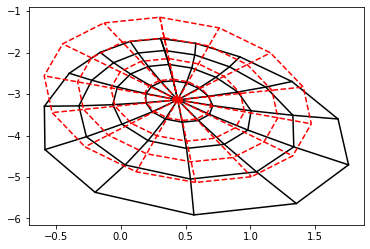

In [10]:
T = 0.05
tt = np.linspace(0, T, num_radii)

metric = G(c0)

all_cc = np.zeros((m, num_radii, num_theta))
all_cc_approx = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    for jj in range(num_radii):
        p0 = all_p0[ii]
        all_cc[:,jj,ii] = exp_map(c0, all_p0[ii], tt[jj])[0]
        all_cc_approx[:,jj,ii] = c0 + np.dot(metric, all_p0[ii] * tt[jj])

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')
    
for ii in range(num_theta):
    plt.plot(all_cc_approx[0,:,ii], all_cc_approx[1,:,ii], '--r')
    
for jj in range(num_radii):
    plt.plot(all_cc_approx[0,jj,:], all_cc_approx[1,jj,:], '--r')

In [11]:
def cdotdot(c, p):
    cd = cdot(c, p)
    pd = pdot(c, p)
    return (2.0 * pd * np.dot(c,  c) +
            4.0 * p  * np.dot(cd, c) +
            2.0 * cd * np.dot(p,  c) +
            2.0 * c  * np.dot(pd, c) +
            2.0 * c  * np.dot(p,  cd))

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cd0 = cdot(c0, p0)
cdd0 = cdotdot(c0, p0)

s = 1e-7
c1, p1 = exp_map(c0, p0, s)
cd1 = cdot(c1, p1)

cdd0_diff = (cd1 - cd0) / s
err_cdotdot = np.linalg.norm(cdd0_diff - cdd0) / np.linalg.norm(cdd0_diff)
print('s=', s, ', err_cdotdot=', err_cdotdot)

s= 1e-07 , err_cdotdot= 9.753236587864142e-07


In [12]:
def apply_dcdot_dp(c, p, h):
    return 2.0 * h * np.dot(c, c) + 2.0 * c * np.dot(h, c) # equals cdot(c,h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cd0 = cdot(c0, p0)
h = np.random.randn(m)
dcdot_dp_h = apply_dcdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
cd1 = cdot(c0, p1)

dcdot_dp_h_diff = (cd1 - cd0) / s

err_dcdot_dp_h = np.linalg.norm(dcdot_dp_h_diff - dcdot_dp_h) / np.linalg.norm(dcdot_dp_h_diff)
print('s=', s, ', err_dcdot_dp_h=', err_dcdot_dp_h)

s= 1e-06 , err_dcdot_dp_h= 1.8894099417147618e-10


In [13]:
def apply_dpdot_dp(c, p, h):
    return -4.0 * c * np.dot(h, p) - 2.0 * h * np.dot(c, p) - 2.0 * p * np.dot(c, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
pd0 = pdot(c0, p0)
h = np.random.randn(m)
dpdot_dp_h = apply_dpdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
pd1 = pdot(c0, p1)

dpdot_dp_h_diff = (pd1 - pd0) / s

err_dpdot_dp_h = np.linalg.norm(dpdot_dp_h_diff - dpdot_dp_h) / np.linalg.norm(dpdot_dp_h_diff)
print('s=', s, ', err_dpdot_dp_h=', err_dpdot_dp_h)

s= 1e-06 , err_dpdot_dp_h= 2.2603743490675e-06


In [14]:
apply_dcdot_dp_T = apply_dcdot_dp

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dcdot_dp_T = np.dot(apply_dcdot_dp(c0, p0, u), v) - np.dot(u, apply_dcdot_dp_T(c0, p0, v))
print('err_apply_dcdot_dp_T=', err_apply_dcdot_dp_T)

err_apply_dcdot_dp_T= 7.105427357601002e-15


In [15]:
def apply_dpdot_dp_T(c, p, h):
    return -4.0 * p * np.dot(h, c) - 2.0 * h * np.dot(c, p) - 2.0 * c * np.dot(p, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dpdot_dp_T = np.dot(apply_dpdot_dp(c0, p0, u), v) - np.dot(u, apply_dpdot_dp_T(c0, p0, v))
print('err_apply_dpdot_dp_T=', err_apply_dpdot_dp_T)

err_apply_dpdot_dp_T= -3.552713678800501e-15


In [16]:
def apply_dcdotdot_dp(c, p, h):
    cd = cdot(c, p)
    pd = pdot(c, p)
    dcd = apply_dcdot_dp(c, p, h)
    dpd = apply_dpdot_dp(c, p, h)
    t1  = 2.0 * dpd * np.dot(c,   c)
    t2a = 4.0 * h   * np.dot(cd,  c) 
    t2b = 4.0 * p   * np.dot(dcd, c)
    t3a = 2.0 * dcd * np.dot(p,   c)
    t3b = 2.0 * cd  * np.dot(h,   c)
    t4  = 2.0 * c   * np.dot(dpd, c)
    t5a = 2.0 * c   * np.dot(h,   cd)
    t5b = 2.0 * c   * np.dot(p,   dcd)
    return t1 + t2a + t2b + t3a + t3b + t4 + t5a + t5b

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cdd0 = cdotdot(c0, p0)
h = np.random.randn(m)
dcdotdot_dp_h = apply_dcdotdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
cdd1 = cdotdot(c0, p1)

dcdotdot_dp_h_diff = (cdd1 - cdd0) / s

err_dcdotdot_dp_h = np.linalg.norm(dcdotdot_dp_h_diff - dcdotdot_dp_h) / np.linalg.norm(dcdotdot_dp_h_diff)
print('s=', s, ', err_dcdotdot_dp_h=', err_dcdotdot_dp_h)

s= 1e-06 , err_dcdotdot_dp_h= 4.3254467293818395e-07


In [17]:
def apply_dcdotdot_dp_T(c, p, h):
    cd = cdot(c, p)
    pd = pdot(c, p)
    p_cph = apply_dpdot_dp_T(c, p, h)
    c_cpc = apply_dcdot_dp_T(c, p, c)
    c_cph = apply_dcdot_dp_T(c, p, h)
    p_cpc = apply_dpdot_dp_T(c, p, c)
    c_cpp = apply_dcdot_dp_T(c, p, p)
    t1  = 2.0 * p_cph * np.dot(c,  c)
    t2a = 4.0 * h     * np.dot(cd, c) 
    t2b = 4.0 * c_cpc * np.dot(p,  h)
    t3a = 2.0 * c_cph * np.dot(p,  c)
    t3b = 2.0 * c     * np.dot(cd, h)
    t4  = 2.0 * p_cpc * np.dot(c,  h)
    t5a = 2.0 * cd    * np.dot(c,  h)
    t5b = 2.0 * c_cpp * np.dot(c,  h)
    return t1 + t2a + t2b + t3a + t3b + t4 + t5a + t5b
    
m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dcdotdot_dp_T = np.dot(apply_dcdotdot_dp(c0, p0, u), v) - np.dot(u, apply_dcdotdot_dp_T(c0, p0, v))
print('err_apply_dcdotdot_dp_T=', err_apply_dcdotdot_dp_T)

err_apply_dcdotdot_dp_T= -5.684341886080802e-14


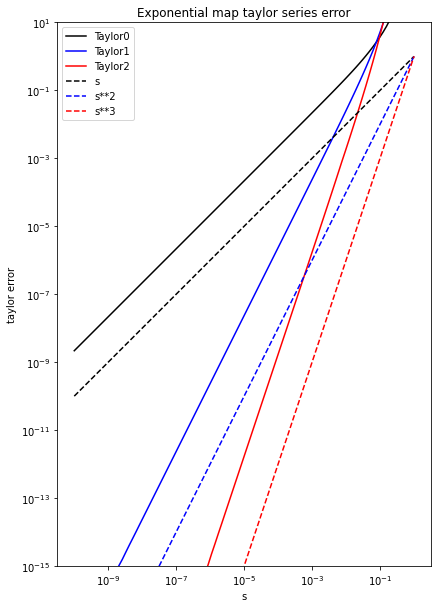

In [18]:
def exp_map_taylor0(c, p, t):
    return c

def exp_map_taylor1(c, p, t):
    return c + t * cdot(c,p)

def exp_map_taylor2(c, p, t):
    return c + t * cdot(c,p) + (t**2 / 2.0) * cdotdot(c,p)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

ss = np.logspace(-10, 0, 100)
all_err_taylor0 = np.zeros(len(ss))
all_err_taylor1 = np.zeros(len(ss))
all_err_taylor2 = np.zeros(len(ss))
for ii in range(len(ss)):
    s = ss[ii]
    es_true = exp_map(c0, p0, s)[0]
    es0 = exp_map_taylor0(c0, p0, s)
    es1 = exp_map_taylor1(c0, p0, s)
    es2 = exp_map_taylor2(c0, p0, s)

    err_taylor0 = np.linalg.norm(es0 - es_true) / np.linalg.norm(es_true)
    err_taylor1 = np.linalg.norm(es1 - es_true) / np.linalg.norm(es_true)
    err_taylor2 = np.linalg.norm(es2 - es_true) / np.linalg.norm(es_true)
    
    all_err_taylor0[ii] = err_taylor0
    all_err_taylor1[ii] = err_taylor1
    all_err_taylor2[ii] = err_taylor2
    
#     print('s=', s, ', err_taylor0=', err_taylor0, ', err_taylor1=', err_taylor1, ', err_taylor2=', err_taylor2)

plt.figure(figsize=(10,10))
plt.loglog(ss, all_err_taylor0, 'k')
plt.loglog(ss, all_err_taylor1, 'b')
plt.loglog(ss, all_err_taylor2, 'r')
plt.loglog(ss, ss, '--k')
plt.loglog(ss, ss**2, '--b')
plt.loglog(ss, ss**3, '--r')
plt.ylim(1e-15, 1e1)
plt.title('Exponential map taylor series error')
plt.xlabel('s')
plt.ylabel('taylor error')
plt.legend(['Taylor0', 'Taylor1', 'Taylor2', 's', 's**2', 's**3'])
plt.gca().set_aspect('equal')

In [19]:
def apply_dexp_map_taylor0_dp(c, p, t, h): # apply to h
    return np.zeros(c.shape)

def apply_dexp_map_taylor1_dp(c, p, t, h): # apply to h
    return t * apply_dcdot_dp(c, p, h)

def apply_dexp_map_taylor2_dp(c, p, t, h): # apply to h
    return t * apply_dcdot_dp(c, p, h) + (t**2 / 2.0) * apply_dcdotdot_dp(c, p, h)


m = 10
c0 = np.random.randn(m)
# p0 = np.random.randn(m)
p0 = np.zeros(m)
T = 0.7
eT0_0 = exp_map(c0, p0, T)[0]
eT1_0 = exp_map(c0, p0, T)[0]
eT2_0 = exp_map(c0, p0, T)[0]
# eT0_0 = exp_map_taylor0(c0, p0, T)
# eT1_0 = exp_map_taylor1(c0, p0, T)
# eT2_0 = exp_map_taylor2(c0, p0, T)

h = np.random.randn(m)
deT0_dp = apply_dexp_map_taylor0_dp(c0, p0, T, h)
deT1_dp = apply_dexp_map_taylor1_dp(c0, p0, T, h)
deT2_dp = apply_dexp_map_taylor2_dp(c0, p0, T, h)

s = 1e-7
p1 = p0 + s * h
eT0_1 = exp_map(c0, p1, T)[0]
eT1_1 = exp_map(c0, p1, T)[0]
eT2_1 = exp_map(c0, p1, T)[0]
# eT0_1 = exp_map_taylor0(c0, p1, T)
# eT1_1 = exp_map_taylor1(c0, p1, T)
# eT2_1 = exp_map_taylor2(c0, p1, T)


deT0_dp_diff = (eT0_1 - eT0_0) / s
deT1_dp_diff = (eT1_1 - eT1_0) / s
deT2_dp_diff = (eT2_1 - eT2_0) / s

err_deT0_dp = np.linalg.norm(deT0_dp_diff - deT0_dp) # should be exact zero
err_deT1_dp = np.linalg.norm(deT1_dp_diff - deT1_dp) / np.linalg.norm(deT1_dp_diff)
err_deT2_dp = np.linalg.norm(deT2_dp_diff - deT2_dp) / np.linalg.norm(deT2_dp_diff)

print('s=', s, ', err_deT0_dp=', err_deT0_dp)
print('s=', s, ', err_deT1_dp=', err_deT1_dp)
print('s=', s, ', err_deT2_dp=', err_deT2_dp)

s= 1e-07 , err_deT0_dp= 66.17698921973637
s= 1e-07 , err_deT1_dp= 9.496794990398049e-07
s= 1e-07 , err_deT2_dp= 9.496794990398049e-07


In [20]:
def apply_dexp_map_taylor0_dp_T(c, p, t, h): # apply to h
    return np.zeros(c.shape)

def apply_dexp_map_taylor1_dp_T(c, p, t, h): # apply to h
    return t * apply_dcdot_dp_T(c, p, h)

def apply_dexp_map_taylor2_dp_T(c, p, t, h): # apply to h
    return t * apply_dcdot_dp_T(c, p, h) + (t**2 / 2.0) * apply_dcdotdot_dp_T(c, p, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
T=0.7

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dexp_map_taylor0_dp_T = (np.dot(apply_dexp_map_taylor0_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor0_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor0_dp_T=', err_apply_dexp_map_taylor0_dp_T)

err_apply_dexp_map_taylor1_dp_T = (np.dot(apply_dexp_map_taylor1_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor1_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor1_dp_T=', err_apply_dexp_map_taylor1_dp_T)

err_apply_dexp_map_taylor2_dp_T = (np.dot(apply_dexp_map_taylor2_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor2_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor2_dp_T=', err_apply_dexp_map_taylor2_dp_T)

err_apply_dexp_map_taylor0_dp_T= 0.0
err_apply_dexp_map_taylor1_dp_T= 0.0
err_apply_dexp_map_taylor2_dp_T= -1.1368683772161603e-13


In [156]:
N = 100 # number of rows/cols of basis matrices
m = 73 # number of basis matrices
r = 3 # number of probing vectors
noise_level = 0.25

BB = [np.random.randn(N,N) for _ in range(m)] # basis matrices
def apply_Bk(x, k):
    return np.dot(BB[k], x)

def apply_Bk_T(x, k):
    return np.dot(BB[k].T, x)

def apply_BB(X, c):
    return np.array([c[k] * apply_Bk(X, k) for k in range(m)])

def apply_BB_adjc(X, Z):
    return np.array([np.sum(X * apply_Bk_T(Z, k)) for k in range(m)])

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_BB_adjc = np.sum(apply_BB(X, c) * Z) - np.sum(c * apply_BB_adjc(X, Z))
print('err_apply_BB_adjc=', err_apply_BB_adjc)

def apply_BB_T(X, c):
    return np.array([c[k] * apply_Bk_T(X, k) for k in range(m)])

def apply_BB_T_adjc(X, Z):
    return np.array([np.sum(X * apply_Bk(Z, k)) for k in range(m)])

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_BB_T_adjc = np.sum(apply_BB_T(X, c) * Z) - np.sum(c * apply_BB_T_adjc(X, Z))
print('err_apply_BB_T_adjc=', err_apply_BB_T_adjc)


def apply_sqrtA(X, c):
    return np.sum(apply_BB(X, c), axis=0)

def apply_sqrtA_adjc(X, Z):
    return apply_BB_adjc(X, Z)

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_sqrtA_adjc = np.sum(apply_sqrtA(X, c) * Z) - np.sum(c * apply_sqrtA_adjc(X, Z))
print('err_apply_sqrtA_adjc=', err_apply_sqrtA_adjc)


def apply_sqrtA_T(x, c):
    return np.sum(apply_BB_T(x, c), axis=0)

def apply_sqrtA_T_adjc(X, Z):
    return apply_BB_T_adjc(X, Z)

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_sqrtA_T_adjc = np.sum(apply_sqrtA_T(X, c) * Z) - np.sum(c * apply_sqrtA_T_adjc(X, Z))
print('err_apply_sqrtA_T_adjc=', err_apply_sqrtA_T_adjc)

apply_A = lambda x, c: apply_sqrtA_T(apply_sqrtA(x, c), c)


c_true = np.random.randn(m)

sqrtA_true = np.zeros((N,N))
for ii in range(m):
    sqrtA_true += c_true[ii] * BB[ii]

x = np.random.randn(N)
y_true = np.dot(sqrtA_true, x)
y = apply_sqrtA(x, c_true)
err_apply_sqrtA = np.linalg.norm(y_true - y) / np.linalg.norm(y_true)
print('err_apply_sqrtA=', err_apply_sqrtA)


x = np.random.randn(N)
y_true = np.dot(sqrtA_true.T, x)
y = apply_sqrtA_T(x, c_true)
err_apply_sqrtA_T = np.linalg.norm(y_true - y) / np.linalg.norm(y_true)
print('err_apply_sqrtA_T=', err_apply_sqrtA_T)

A_true = np.dot(sqrtA_true.T, sqrtA_true)

X = np.random.randn(N, r)
Y1 = np.dot(A_true, X)
Y2 = apply_A(X, c_true)
err_apply_A = np.linalg.norm(Y1 - Y2) / np.linalg.norm(Y2)
print('err_apply_A=', err_apply_A)

err_apply_BB_adjc= 2.2737367544323206e-13
err_apply_BB_T_adjc= -7.958078640513122e-13
err_apply_sqrtA_adjc= -4.547473508864641e-13
err_apply_sqrtA_T_adjc= -9.094947017729282e-13
err_apply_sqrtA= 5.941339020082049e-16
err_apply_sqrtA_T= 7.911686193568563e-16
err_apply_A= 6.658791618514469e-16


In [157]:
Omega = np.random.randn(N,r)
Y_nonoise = apply_A(Omega, c_true)
Noise = np.random.randn(N,r)
Noise = noise_level * (np.linalg.norm(Y_nonoise) / np.linalg.norm(Noise)) * Noise
Y = Y_nonoise + Noise

BB_Omega = np.array([apply_Bk(Omega, k) for k in range(m)])
sqrtA_true_Omega = np.sum([c_true[k] * BB_Omega[k,:,:] for k in range(m)], axis=0)
err_sqrtA_true_Omega = np.linalg.norm(apply_sqrtA(Omega, c_true) - sqrtA_true_Omega)
print('err_sqrtA_true_Omega=', err_sqrtA_true_Omega)

err_sqrtA_true_Omega= 0.0


In [158]:
# fwd = lambda c: apply_A(Omega, c)
fwd = lambda c: apply_sqrtA_T(apply_sqrtA(Omega, c), c)

apply_Jac = lambda c, h: apply_sqrtA_T(apply_sqrtA(Omega, c), h) + apply_sqrtA_T(apply_sqrtA(Omega, h), c) # good

c0 = np.random.randn(m)
f0 = fwd(c0)

h = np.random.randn(m)
df0 = apply_Jac(c0, h)

s = 1e-7
c1 = c0 + s*h
f1 = fwd(c1)

df0_diff = (f1 - f0) / s
err_Jac = np.linalg.norm(df0_diff - df0) / np.linalg.norm(df0_diff)
print('s=', s, ', err_Jac=', err_Jac)

s= 1e-07 , err_Jac= 9.711904585447633e-08


In [159]:
apply_Jac = lambda c, h: apply_sqrtA_T(apply_sqrtA(Omega, c), h) + apply_sqrtA_T(apply_sqrtA(Omega, h), c)

def apply_Jac_T(c, H):
    t1 = apply_sqrtA_T_adjc(apply_sqrtA(Omega, c), H)
    t2 = apply_sqrtA_adjc(Omega, apply_sqrtA(H, c))
    return t1 + t2

c = np.random.randn(m)

h = np.random.randn(m)
H = np.random.randn(N,r)

err_apply_Jac_T = np.sum(apply_Jac(c,h) * H) - np.sum(h * apply_Jac_T(c,H))
print('err_apply_Jac_T=', err_apply_Jac_T)

err_apply_Jac_T= -5.820766091346741e-11


In [160]:
def misfit(c):
    return 0.5 * np.linalg.norm(Y - fwd(c))**2

misfit_true = misfit(c_true)
print('misfit_true=', misfit_true)

c0 = np.random.randn(m)
misfit0 = misfit(c0)
print('misfit0=', misfit0)

misfit_true= 2194585310.388356
misfit0= 26657161357.652485


In [161]:
def gradient(c):
    return -apply_Jac_T(c, Y - fwd(c))

c0 = np.random.randn(m)
J0 = misfit(c0)
G0 = gradient(c0)

h = np.random.randn(m)
dJ = np.dot(h, G0)

s = 1e-7
c1 = c0 + s*h
J1 = misfit(c1)

dJ_diff = (J1 - J0) / s
err_grad = np.linalg.norm(dJ_diff - dJ) / np.linalg.norm(dJ_diff)
print('s=', s, ', err_grad=', err_grad)

s= 1e-07 , err_grad= 1.6639569078797015e-06


In [162]:
def apply_gauss_newton_hessian(c, h):
    return apply_Jac_T(c, apply_Jac(c, h))

c0 = c_true
G0 = gradient(c0)

h = np.random.randn(m)
dG = apply_gauss_newton_hessian(c0, h)

s=1e-7
c1 = c0 + s*h
G1 = gradient(c1)

dG_diff = (G1 - G0) / s
err1_gnhess = np.linalg.norm(dG - dG_diff) / np.linalg.norm(dG_diff)
print('s=', s, ', err1_gnhess=', err1_gnhess)

s= 1e-07 , err1_gnhess= 0.11806799573229258


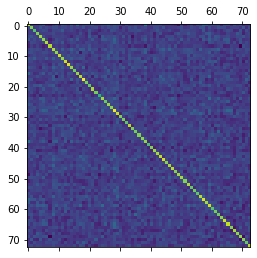

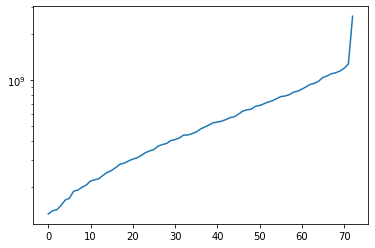

In [163]:
def build_dense_Hgn(c):
    Hgn = np.zeros((m,m))
    for ii in range(m):
        ei = np.zeros(m)
        ei[ii] = 1.0
        Hgn[:,ii] = apply_gauss_newton_hessian(c, ei)
    return Hgn

# c = c_true
# c = np.random.randn(m)
# c = np.zeros(m) # GN Hessian is zero here
c = np.ones(m)

Hgn = build_dense_Hgn(c)
evals, evecs = sla.eigh(Hgn)
    
plt.matshow(Hgn)

plt.figure()
plt.semilogy(evals)

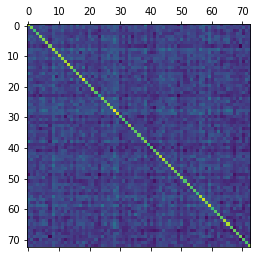

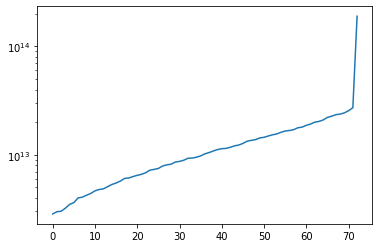

In [164]:
metric = G(c)

evals, evecs = sla.eigh(metric @ Hgn @ metric)

plt.matshow(metric @ Hgn @ metric)

plt.figure()
plt.semilogy(evals)

In [165]:
# Simple Newton iteration

a=1.0
c = np.ones(m)
norm_G0 = np.linalg.norm(gradient(c))
for k  in range(25):
    Gk = gradient(c)
    norm_Gk = np.linalg.norm(Gk)
    if (norm_Gk / norm_G0 < 1e-11):
        break
    print('norm_Gk / norm_G0=', norm_Gk / norm_G0)
    Hgn = build_dense_Hgn(c)
    p = -np.linalg.solve(Hgn, Gk)
    c = c + a * p
#     print('c=', c)

c_star = c.copy()
print('c_star=', c_star)
print('c_true=', c_true)

norm_Gk / norm_G0= 1.0
norm_Gk / norm_G0= 0.68842804132212
norm_Gk / norm_G0= 0.3650309709251428
norm_Gk / norm_G0= 0.47817915476088596
norm_Gk / norm_G0= 0.49511039684757036
norm_Gk / norm_G0= 0.2719112292723955
norm_Gk / norm_G0= 0.052827131564842277
norm_Gk / norm_G0= 0.0069315721848054734
norm_Gk / norm_G0= 0.001763608131592683
norm_Gk / norm_G0= 0.00046852310945968544
norm_Gk / norm_G0= 0.00013761165035499172
norm_Gk / norm_G0= 3.839854248895896e-05
norm_Gk / norm_G0= 1.160707297942241e-05
norm_Gk / norm_G0= 3.2817156954062914e-06
norm_Gk / norm_G0= 1.0044075429434608e-06
norm_Gk / norm_G0= 2.8530564332194026e-07
norm_Gk / norm_G0= 8.803188071691225e-08
norm_Gk / norm_G0= 2.505434297652876e-08
norm_Gk / norm_G0= 7.783050386576373e-09
norm_Gk / norm_G0= 2.216956978822698e-09
norm_Gk / norm_G0= 6.930285132450525e-10
norm_Gk / norm_G0= 1.974795578241522e-10
norm_Gk / norm_G0= 6.210787176750368e-11
norm_Gk / norm_G0= 1.7702614562658913e-11
c_star= [-0.37028741 -0.93186582  1.25142385 

In [166]:
final_relative_residual = np.linalg.norm(Y - fwd(c_star)) / np.linalg.norm(Y)
print('final_relative_residual', final_relative_residual)

final_relative_residual 0.20389887890926228


k= 0 , delta_dc= 0.0 , norm_Gk / norm_G0= 1.0 , err= 1.2233213562824732
a= 0.9696969696969697
k= 1 , delta_dc= 0.32777789514013794 , norm_Gk / norm_G0= 0.6549753733017741 , err= 1.162343503563685
a= 1.4141414141414144
k= 2 , delta_dc= 0.24876330997134483 , norm_Gk / norm_G0= 0.45030648720640476 , err= 1.0353462830576148
a= 1.090909090909091
k= 3 , delta_dc= 0.23192460824521147 , norm_Gk / norm_G0= 0.5855094352741319 , err= 0.7987847061201949
a= 1.090909090909091
k= 4 , delta_dc= 0.23872616865577556 , norm_Gk / norm_G0= 0.5498795533595235 , err= 0.400292423621056
a= 1.191919191919192
k= 5 , delta_dc= 0.165733293819931 , norm_Gk / norm_G0= 0.1911018526889542 , err= 0.10125664334444574
a= 1.090909090909091
k= 6 , delta_dc= 0.04589158423268857 , norm_Gk / norm_G0= 0.01772875638185876 , err= 0.017661671114423638
a= 1.0101010101010102
k= 7 , delta_dc= 0.007681430853106144 , norm_Gk / norm_G0= 0.0034303004100132584 , err= 0.005130339890812882
a= 1.0303030303030305
k= 8 , delta_dc= 0.002293113

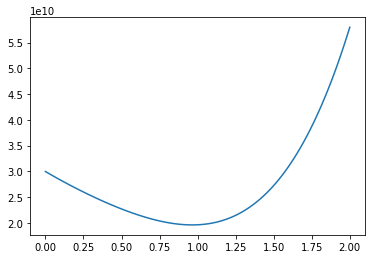

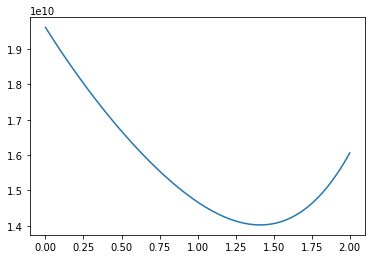

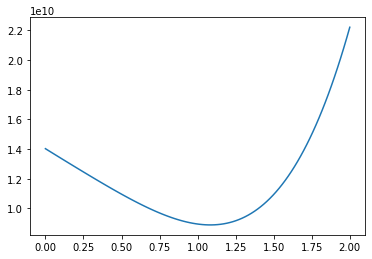

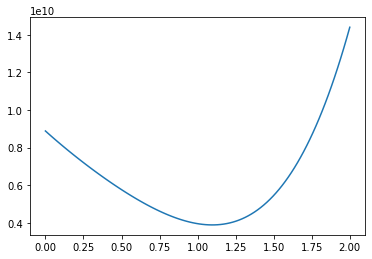

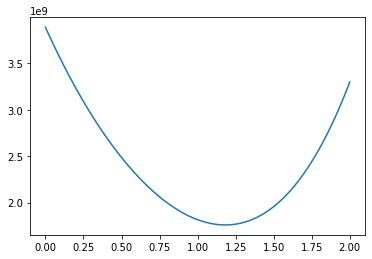

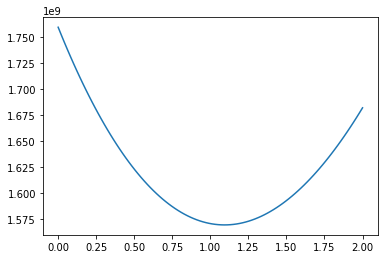

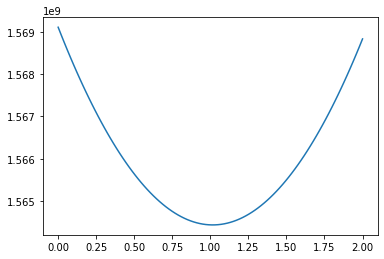

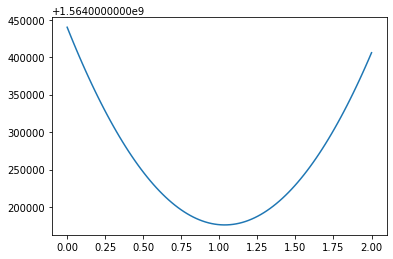

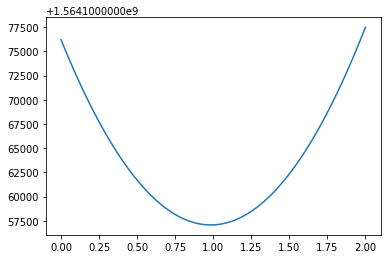

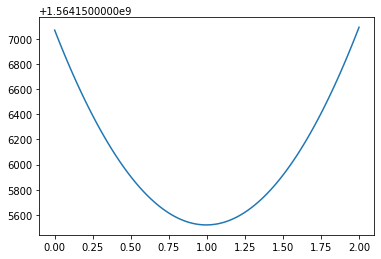

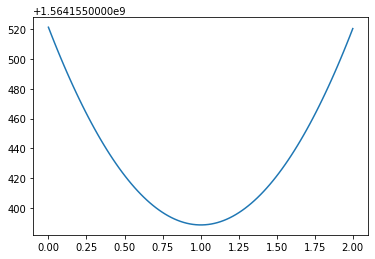

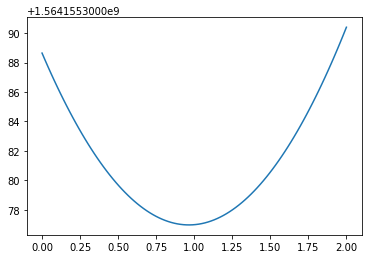

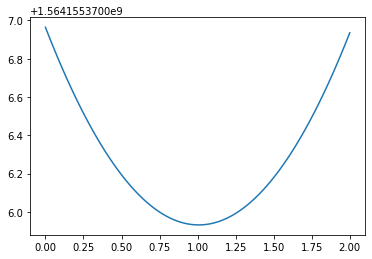

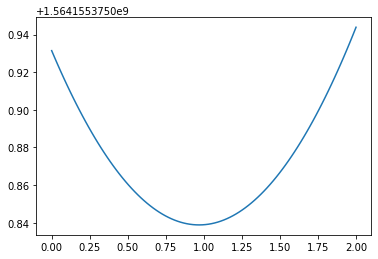

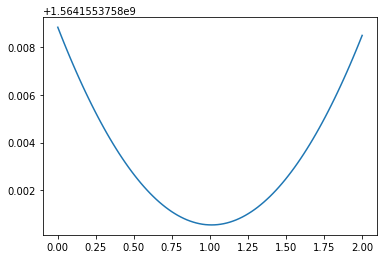

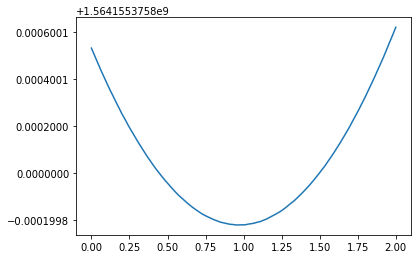

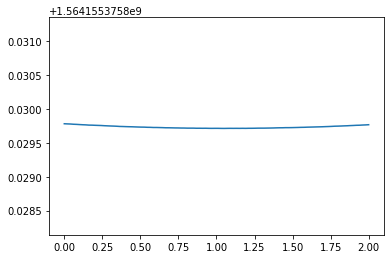

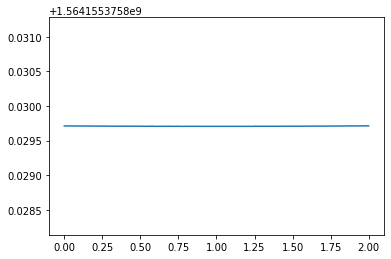

In [169]:
# Geodesic Newton iteration
use_exp = True
# use_exp = False

a=1.0
c = np.ones(m)
norm_G0 = np.linalg.norm(gradient(c))
delta_dc = 0.0
for k  in range(50):
#     if k < 100:
#         a = 0.125
#     else:
#         a = 1.0
    Gk = gradient(c)
    norm_Gk = np.linalg.norm(Gk)
    err = np.linalg.norm(c_star - c) / np.linalg.norm(c_star)
    print('k=', k, ', delta_dc=', delta_dc, ', norm_Gk / norm_G0=', norm_Gk / norm_G0, ', err=', err)
    if (norm_Gk / norm_G0 < 1e-8):
        break
    
    metric = G(c)
    
    Hgn = build_dense_Hgn(c)
    p0 = -np.linalg.solve(Hgn, Gk)
    p = np.linalg.solve(metric, p0)
    
    if use_exp:    
        ls_func = lambda s: misfit(exp_map(c, p, s)[0])
#         gg_func = lambda s: np.linalg.norm(gradient(exp_map(c, p, s)[0]))
    else:
        ls_func = lambda s: misfit(c + s * p0)
#         gg_func = lambda s: np.linalg.norm(gradient(c + s * p0))

    ss = list(np.linspace(0.0, 2.0, 100))
    ff = [ls_func(s) for s in ss]
#     gg = [gg_func(s) for s in ss]
    
    
    plt.figure()
    plt.plot(ss, ff)
#     plt.plot(ss, gg)
#     plt.legend(['f', 'g'])
  
    a = ss[np.argmin(ff)]
    print('a=', a)
    
    new_c = c + a * p0
    new_c_exp = exp_map(c, p, a)[0]
    
    dc = new_c - c
    dc_exp = new_c_exp - c
    delta_dc = np.linalg.norm(dc - dc_exp) / np.linalg.norm(dc)
    
    if use_exp:
        c = new_c_exp
    else:
        c = new_c
    
# print('c=', c)
# print('c_true=', c_true)

In [170]:
final_relative_residual = np.linalg.norm(Y - fwd(c)) / np.linalg.norm(Y)
print('final_relative_residual', final_relative_residual)

final_relative_residual 0.2038988789092623


In [176]:
sqrtA = np.zeros((N,N))
for ii in range(m):
    sqrtA += c[ii] * BB[ii]

A = np.dot(sqrtA.T, sqrtA)

err_A = np.linalg.norm(A - A_true) / np.linalg.norm(A_true)
print('err_A=', err_A)

err_A= 0.16706302857955635


In [ ]:
raise RuntimeError

In [ ]:
# Standard Newton iteration

c_armijo=1e-4
max_backtracking_iter = 10

c = np.ones(m)
norm_G0 = np.linalg.norm(gradient(c))
delta_dc = 0.0
for k  in range(20):
    Gk = gradient(c)
    norm_Gk = np.linalg.norm(Gk)
    err = np.linalg.norm(c_star - c) / np.linalg.norm(c_star)
    print('k=', k, ', delta_dc=', delta_dc, ', norm_Gk / norm_G0=', norm_Gk / norm_G0, ', err=', err)
    if (norm_Gk / norm_G0 < 1e-11):
        break
    
    metric = G(c)
    
    Hgn = build_dense_Hgn(c)
    p0 = -np.linalg.solve(Hgn, Gk)
    p = np.linalg.solve(metric, p0)
    
    alpha = 1.0
    descent = 0
    n_backtrack = 0
    
    gdm = inner_product(g, dm)
    
    cost_old = current_cost
    mstar = copy_vector(m)
    while descent == 0 and n_backtrack < max_backtracking_iter:
        mstar = m + a*p

        cost_new = misfit(mstar)

        # Check if armijo conditions are satisfied
        if (cost_new < cost_old + alpha * c_armijo * gdm) or (-gdm <= gdm_tol):
            cost_old = cost_new
            descent = 1
            m = mstar
            set_optimization_variable(mstar)
        else:
            n_backtrack += 1
            alpha *= 0.5
    
    new_c = c + a * p0
    new_c_exp = exp_map(c, p, a)[0]
    
    dc = new_c - c
    dc_exp = new_c_exp - c
    delta_dc = np.linalg.norm(dc - dc_exp) / np.linalg.norm(dc)
    
#     c = new_c_exp
    c = new_c
    
# print('c=', c)
# print('c_true=', c_true)

In [ ]:
raise RuntimeError('ASDF')

In [ ]:
def misfit_exp(c0, p):
    return misfit(exp_map(c0, p0, 1.0)[0])
    
def gradient_exp(c0, p):
#     def apply_dpdot_dp(c, p, h):
#     return -4.0 * c * np.dot(h, p) - 2.0 * h * np.dot(c, p) - 2.0 * p * np.dot(c, h)
    return apply_dexp_map_taylor1_dp_T(c0, p, 1.0, gradient(c0))

c0 = np.random.randn(m)
p0 = np.random.randn(m)
J0 = misfit_exp(c0, p0)
G0 = gradient_exp(c0, p0)

dp = np.random.randn(m)
dJ = np.dot(G0, dp)

s = 1e-6
p1 = p0 + s*dp
J1 = misfit_exp(c0, p1)

dJ_diff = (J1 - J0) / s
err_gradient_exp = np.linalg.norm(dJ_diff - dJ) / np.linalg.norm(dJ_diff)
print('err_gradient_exp=', err_gradient_exp)


In [ ]:
np.linalg.eigh(G(c0))[0]

In [ ]:
# c0 = np.random.randn(m)
# c0 = c_true
c0 = c
p0 = np.random.randn(m)

h = gradient(c0)
PSI = -4.0 * np.outer(c0, h) - 2.0 * np.outer(h, c0) - 2.0 * np.dot(c0, h) * np.eye(m)

2.0 * h * np.dot(c, c) + 2.0 * c * np.dot(h, c)

ee_PSI = np.linalg.eigh(PSI)[0]
print(ee_PSI)

plt.plot(ee_PSI)

np.linalg.cond(PSI)

In [ ]:
# Geodesic Newton iteration

a=1.0
c = np.ones(m)
norm_G0 = np.linalg.norm(gradient(c))
for k  in range(25):
    Gk = gradient(c)
    norm_Gk = np.linalg.norm(Gk)
    if (norm_Gk / norm_G0 < 1e-11):
        break
    print('norm_Gk / norm_G0=', norm_Gk / norm_G0)
    
    metric = G(c)
    
    Hgn = build_dense_Hgn(c)
    p = -np.linalg.solve(metric @ Hgn @ metric, metric @ Gk)
    c = exp_map(c0, p, a)[0]
#     c = c + a * p
    
print('c=', c)
print('c_true=', c_true)

In [ ]:
-4.0 * c0 * np.dot(h, p0) - 2.0 * h * np.dot(c0, p0) - 2.0 * p0 * np.dot(c0, h)

In [ ]:
gradient(c)